# EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [ ]:
from utils import clear_text, get_doc_emb

In [ ]:
FILE_PATH = "bbc-text.csv"

column_name = {
    "text": "text",
    "label": "category"
}

In [4]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df.head()

,category,text
2003,business,mild winter drives us oil down 6% us oil price...
880,entertainment,roundabout continues nostalgia trip the new bi...
1197,business,record year for chilean copper chile s copper ...
2126,politics,boris opposes mayor apology ken livingstone sh...
353,sport,pearce keen on succeeding keegan joint assista...


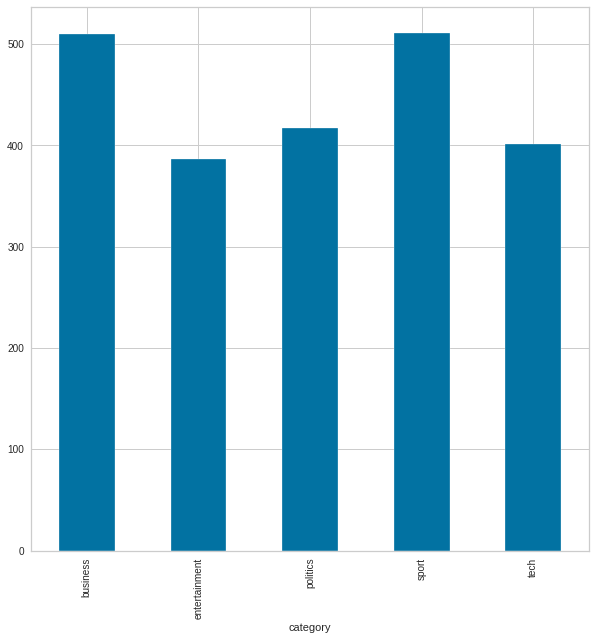

In [45]:
encoder = LabelEncoder()
data_df["category_enc"] = encoder.fit_transform(data_df["category"])
data_df.groupby('category').category.count().plot.bar(grid=True,figsize=(10, 10));

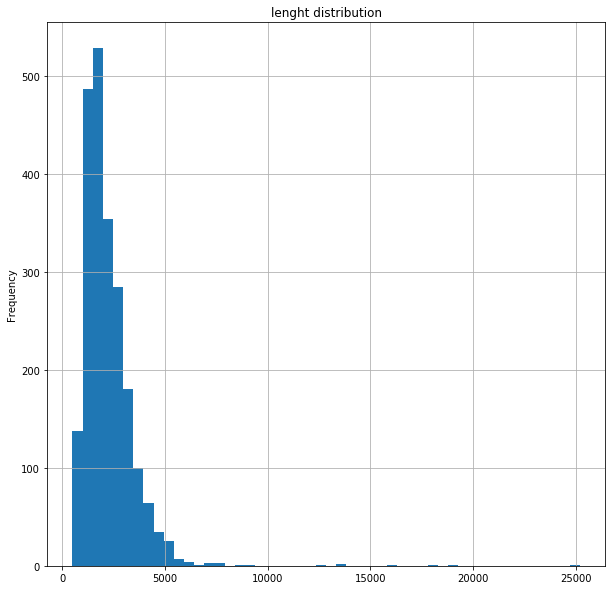

In [6]:
data_df[column_name["text"]] = clear_text(data_df["text"])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="lenght distribution", grid=True, figsize=(10,10), bins=50);
# data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# Encode text into GUSE embeddings

In [ ]:
import tensorflow_hub as hub

URL = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
emb_module = hub.Module(URL)

In [8]:
data = get_doc_emb(emb_module, data_df.text.values)
data.shape

W0814 10:00:46.377511 140564501841792 deprecation_wrapper.py:119] From /content/utils.py:29: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0814 10:00:47.743239 140564501841792 deprecation_wrapper.py:119] From /content/utils.py:30: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W0814 10:00:50.643960 140564501841792 deprecation_wrapper.py:119] From /content/utils.py:31: The name tf.tables_initializer is deprecated. Please use tf.compat.v1.tables_initializer instead.



(2225, 512)

# Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

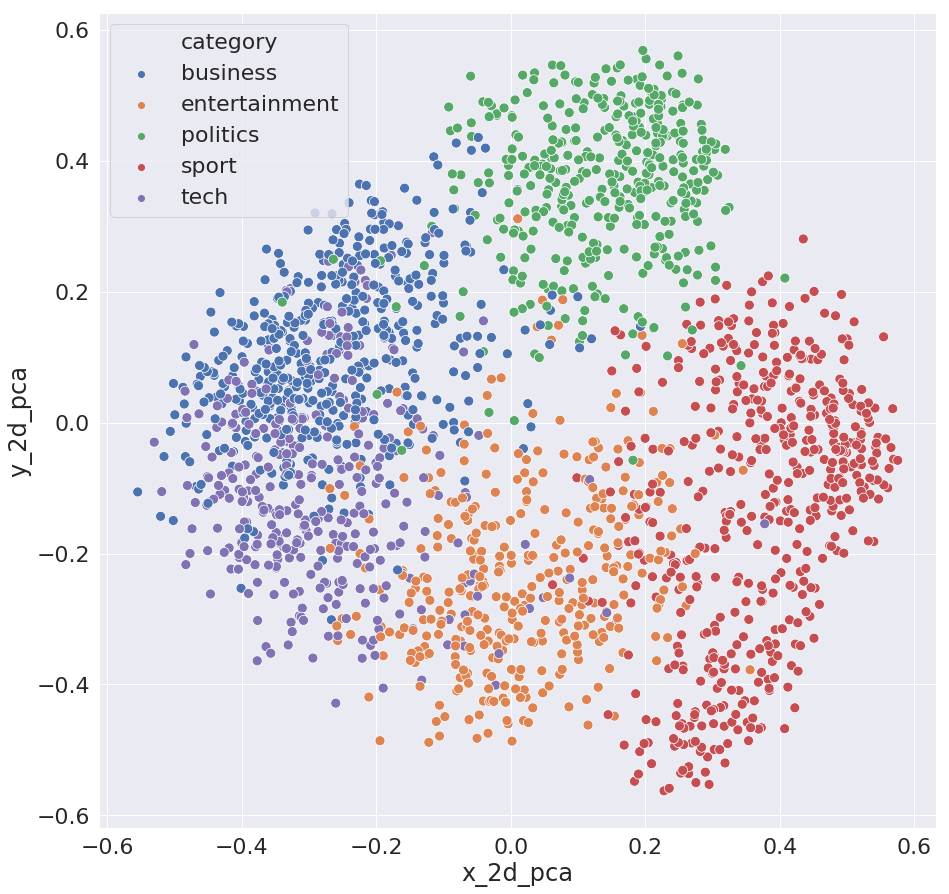

In [11]:
#reduce down to 2 dim
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

data_df["x_2d_pca"] = data_pca[:, 0]
data_df["y_2d_pca"] = data_pca[:, 1]

plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_pca",
    y="y_2d_pca",
    hue="category",
    data=data_df,
    s=100
);

# Principal Component Analysis + t-SNE

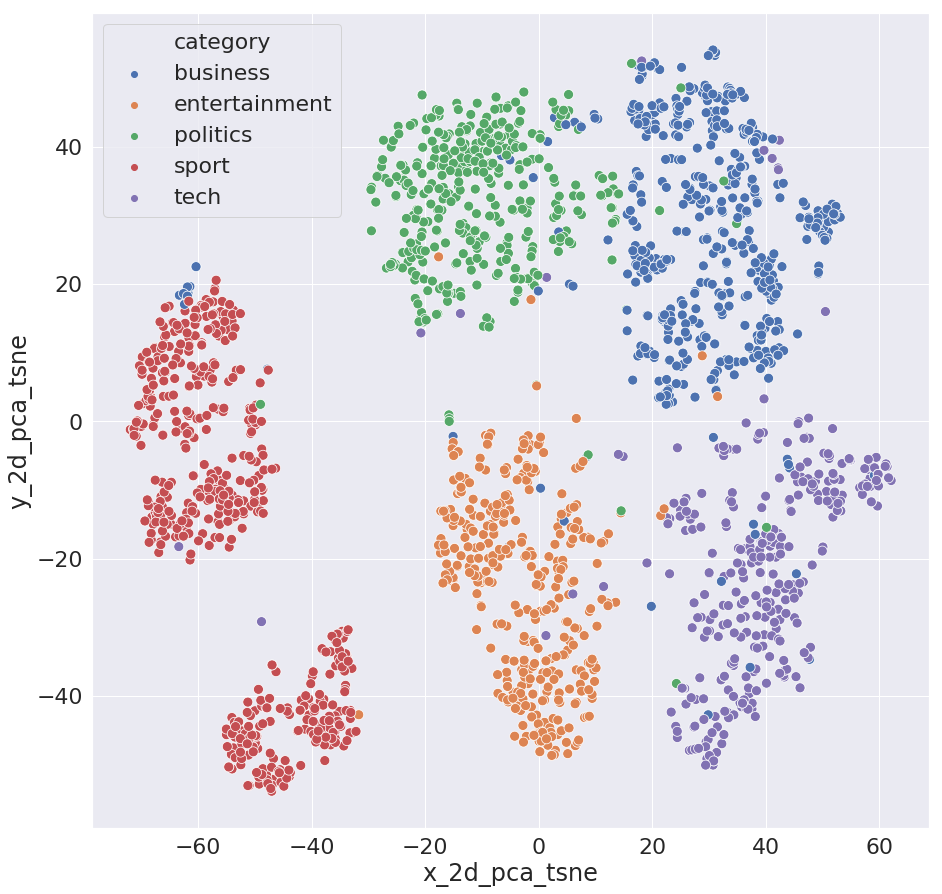

In [12]:
#reduce down to 50 dim
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)

#further reduce to 2 dim using t-SNE
data_pca_tsne = TSNE(n_components=2).fit_transform(data_pca)

data_df["x_2d_pca_tsne"] = data_pca_tsne[:, 0]
data_df["y_2d_pca_tsne"] = data_pca_tsne[:, 1]

plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_pca_tsne",
    y="y_2d_pca_tsne",
    hue="category",
    data=data_df,
    s=100
);

# Non Linear Probabilistic Component Analysis

In [ ]:
!pip3 install inferpy

In [ ]:
import inferpy as inf
import tensorflow as tf

In [ ]:
# number of components
n_comp = 2
# size of the hidden layer in the NN
hidden_dim = 10
# dimensionality of the data
data_dim = 512


def decoder(z, hidden_dim, data_dim):
    h = tf.layers.dense(inputs=z, units=hidden_dim, activation=tf.nn.relu)
    return tf.layers.dense(inputs=h, units=2*data_dim)


# model scheme
@inf.probmodel
def nlpca(n_comp, hidden_dim, data_dim, decoder):

    with inf.datamodel() as m:
        z = inf.Normal(loc=tf.ones([n_comp]) * 0.5, scale=1.0, name="z")# shape = [N, n_comp]
        output = decoder(z, hidden_dim, data_dim)
        x_loc = output[:, :data_dim]
        x_scale = tf.nn.softmax(output[:,data_dim:])
        x = inf.Normal(x_loc, x_scale, name="x")# shape = [N,d]

# inference
@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(initial_value=tf.ones([k]) * 0.5, name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(initial_value=tf.ones([k]), name="qz_scale"))

        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

In [28]:
model = nlpca(n_comp, hidden_dim, data_dim, decoder)

# set the inference algorithm
VI = inf.inference.VI(qmodel(n_comp), epochs=50000)

# learn the parameters
model.fit({"x": data}, VI)


 0 epochs	 1194051968.0....................
 200 epochs	 190530720.0....................
 400 epochs	 186323072.0....................
 600 epochs	 185453600.0....................
 800 epochs	 185029056.0....................
 1000 epochs	 184755216.0....................
 1200 epochs	 184526976.0....................
 1400 epochs	 184463760.0....................
 1600 epochs	 184375808.0....................
 1800 epochs	 184330224.0....................
 2000 epochs	 184285936.0....................
 2200 epochs	 184272496.0....................
 2400 epochs	 184320848.0....................
 2600 epochs	 184279072.0....................
 2800 epochs	 184281424.0....................
 3000 epochs	 184228304.0....................
 3200 epochs	 184318544.0....................
 3400 epochs	 184261328.0....................
 3600 epochs	 184235776.0....................
 3800 epochs	 184055616.0....................
 4000 epochs	 183986480.0....................
 4200 epochs	 183675104.0..............

In [ ]:
#extract the hidden representation
hidden_encoding = model.posterior("z")
data_nlpca = hidden_encoding.sample()

data_df["x_2d_nlpca"] = data_nlpca[:, 0]
data_df["y_2d_nlpca"] = data_nlpca[:, 1]

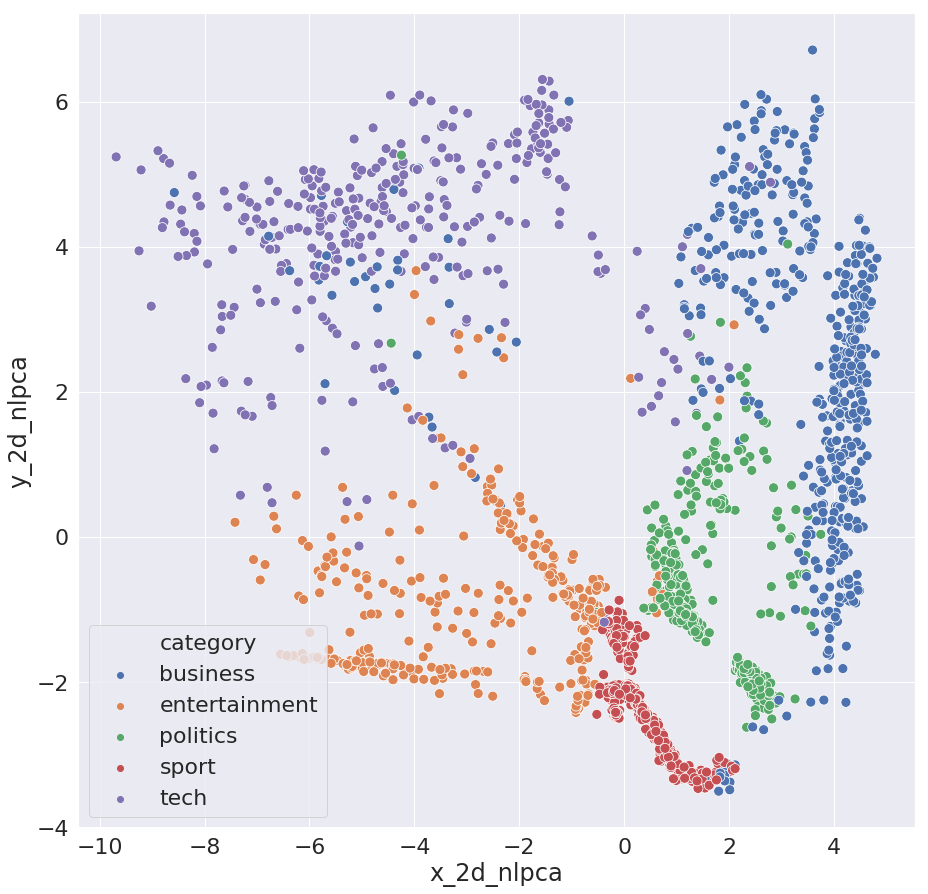

In [30]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_nlpca",
    y="y_2d_nlpca",
    hue="category",
    data=data_df,
    s=100
);

# Non Linear Probabilistic Component Analysis + t-SNE

In [ ]:
# number of components
n_comp = 50
# size of the hidden layer in the NN
hidden_dim = 10
# dimensionality of the data
data_dim = 512


def decoder(z, hidden_dim, data_dim):
    h = tf.layers.dense(inputs=z, units=hidden_dim, activation=tf.nn.relu)
    return tf.layers.dense(inputs=h, units=2*data_dim)


# model scheme
@inf.probmodel
def nlpca(n_comp, hidden_dim, data_dim, decoder):

    with inf.datamodel() as m:
        z = inf.Normal(loc=tf.ones([n_comp]) * 0.5, scale=1.0, name="z")# shape = [N, n_comp]
        output = decoder(z, hidden_dim, data_dim)
        x_loc = output[:, :data_dim]
        x_scale = tf.nn.softmax(output[:,data_dim:])
        x = inf.Normal(x_loc, x_scale, name="x")# shape = [N,d]

# inference
@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(initial_value=tf.ones([k]) * 0.5, name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(initial_value=tf.ones([k]), name="qz_scale"))

        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

In [22]:
model = nlpca(n_comp, hidden_dim, data_dim, decoder)

# set the inference algorithm
VI = inf.inference.VI(qmodel(n_comp), epochs=50000)

# learn the parameters
model.fit({"x": data}, VI)


 0 epochs	 4566890496.0....................
 200 epochs	 202670224.0....................
 400 epochs	 190122272.0....................
 600 epochs	 187575360.0....................
 800 epochs	 186533936.0....................
 1000 epochs	 185832384.0....................
 1200 epochs	 185397680.0....................
 1400 epochs	 185075312.0....................
 1600 epochs	 184802032.0....................
 1800 epochs	 184739936.0....................
 2000 epochs	 184546736.0....................
 2200 epochs	 184574256.0....................
 2400 epochs	 184503776.0....................
 2600 epochs	 184451424.0....................
 2800 epochs	 184437296.0....................
 3000 epochs	 184496768.0....................
 3200 epochs	 184515424.0....................
 3400 epochs	 184378928.0....................
 3600 epochs	 184418112.0....................
 3800 epochs	 184173600.0....................
 4000 epochs	 183706208.0....................
 4200 epochs	 182848016.0..............

In [ ]:
#extract the hidden representation
hidden_encoding = model.posterior("z")
data_nlpca = hidden_encoding.sample()

#further reduce to 2 dim using t-SNE
data_nlpca_tsne = TSNE(n_components=2).fit_transform(data_nlpca)
data_df["x_2d_nlpca_tsne"] = data_nlpca_tsne[:, 0]
data_df["y_2d_nlpca_tsne"] = data_nlpca_tsne[:, 1]

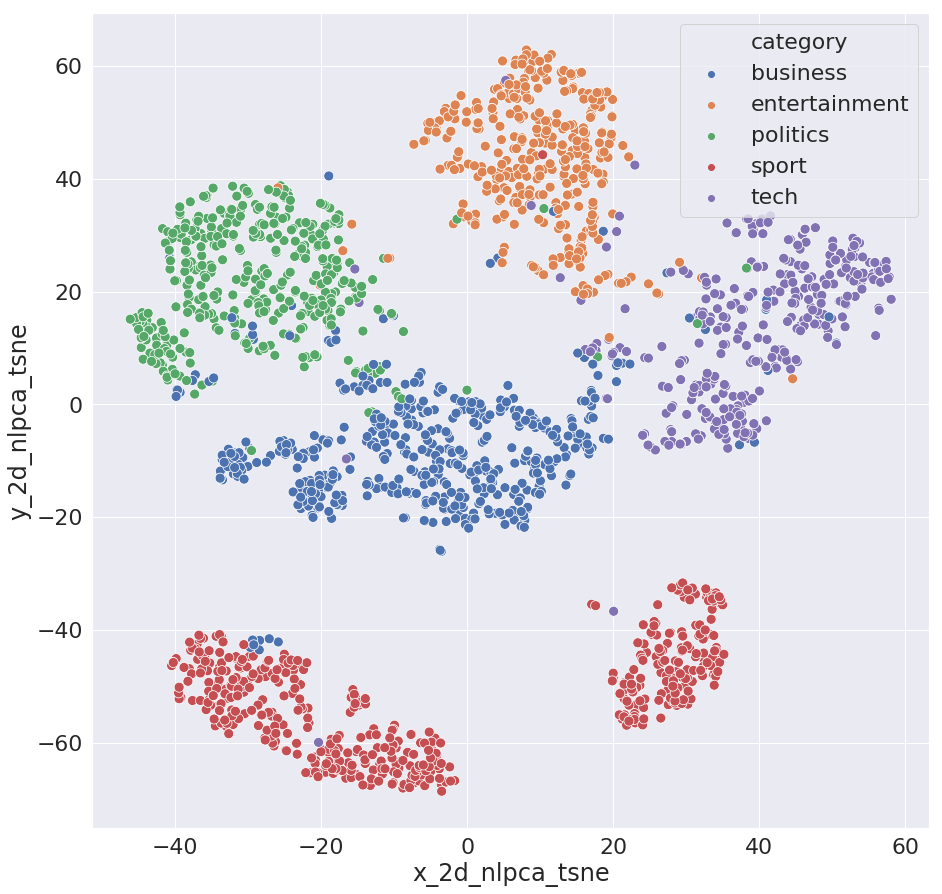

In [25]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_nlpca_tsne",
    y="y_2d_nlpca_tsne",
    hue="category",
    data=data_df,
    s=100
);

# Baseline

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, data_df.category_enc.values, test_size=0.20, random_state=42, stratify=data_df.category_enc)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError, ClassificationReport
from sklearn.metrics import log_loss

label_encoder = dict(enumerate(encoder.classes_))
classes = list(label_encoder.values())

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf_clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
y_pred = rf_clf.predict_proba(x_test)
print("Accuracy {:.4f} and Cross-Entropy Loss {:.4f} for test data".format(rf_clf.score(x_test, y_test), log_loss(y_test, y_pred)))

Accuracy 0.9393 and Cross-Entropy Loss 0.3030 for test data


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


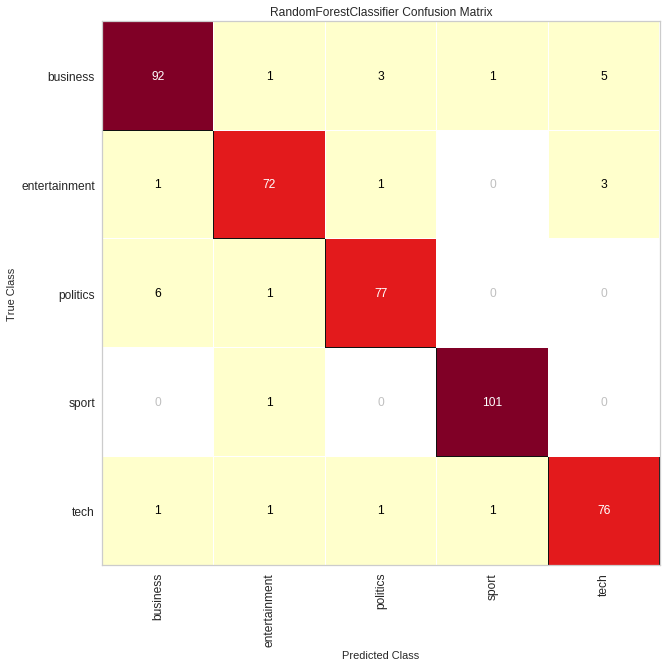

In [36]:
plt.figure(figsize=(10, 10))
visualizer = ConfusionMatrix(rf_clf, classes=classes, label_encoder=label_encoder)
visualizer.score(x_test, y_test)
visualizer.poof()

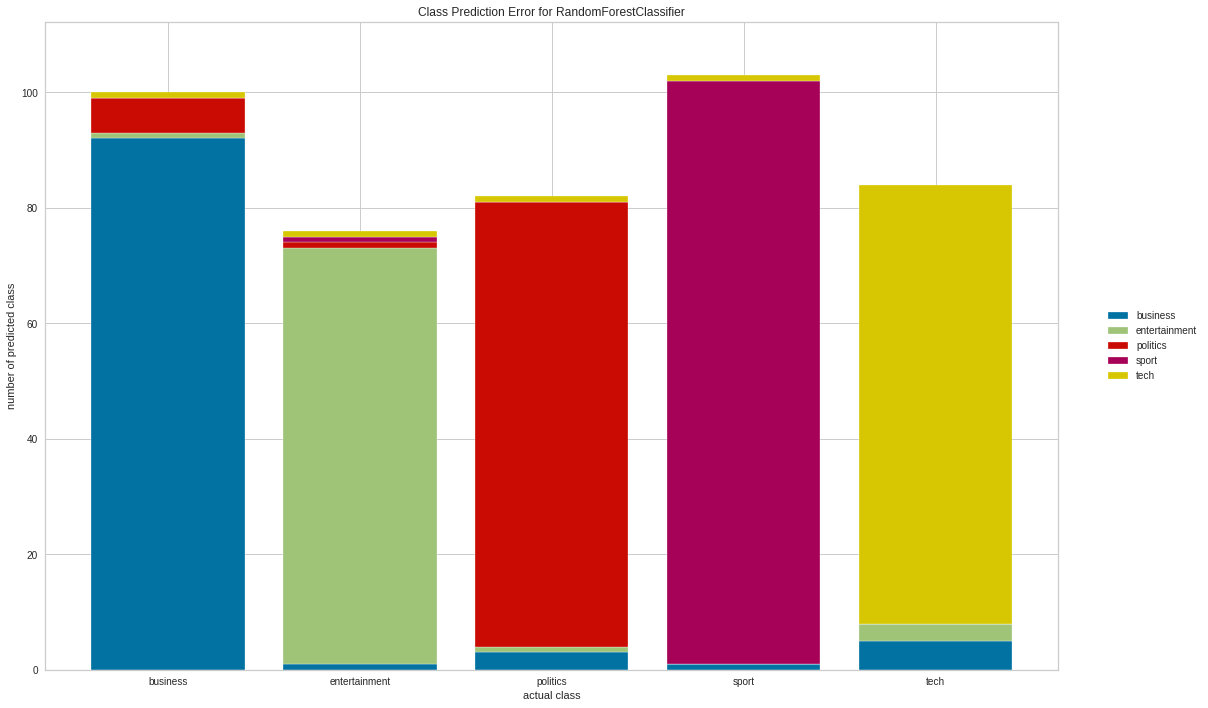

In [37]:
plt.figure(figsize=(20,10))
visualizer = ClassPredictionError(
    model=rf_clf, classes=classes
)

visualizer.score(x_test, y_test)
visualizer.poof()

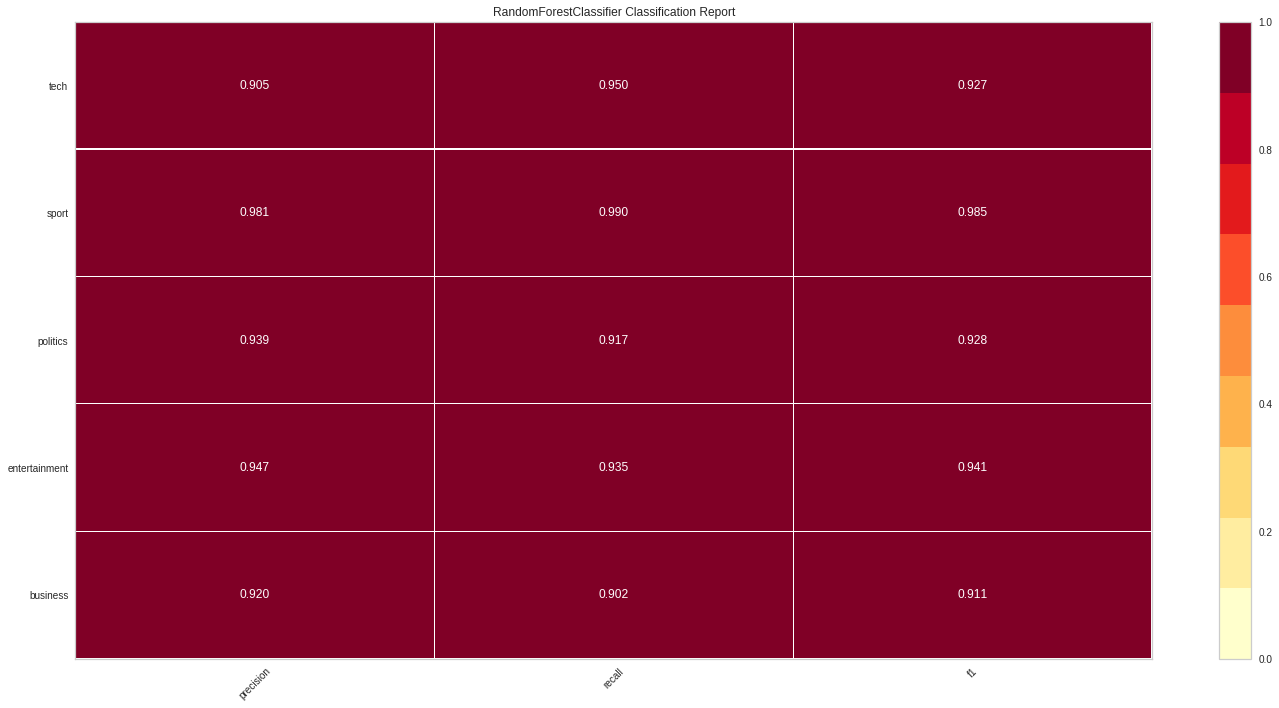

In [38]:
plt.figure(figsize=(20,10))
visualizer = ClassificationReport(model=rf_clf, classes=classes)
visualizer.score(x_test, y_test)
visualizer.poof()

## XGBoost  Classifier

In [ ]:
from xgboost import XGBClassifier

In [40]:
default_params = {
    "objective": "multi:softmax",
    "num_class": 5
}

xgb_clf = XGBClassifier()
xgb_clf.fit(X=x_train, y=y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=20, eval_metric=['merror', "mlogloss"])

[0]	validation_0-merror:0.060674	validation_0-mlogloss:1.40871	validation_1-merror:0.096629	validation_1-mlogloss:1.41664
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.041948	validation_0-mlogloss:1.2467	validation_1-merror:0.085393	validation_1-mlogloss:1.26648
[2]	validation_0-merror:0.033708	validation_0-mlogloss:1.11256	validation_1-merror:0.080899	validation_1-mlogloss:1.14363
[3]	validation_0-merror:0.021723	validation_0-mlogloss:0.998594	validation_1-merror:0.060674	validation_1-mlogloss:1.03547
[4]	validation_0-merror:0.020225	validation_0-mlogloss:0.901126	validation_1-merror:0.058427	validation_1-mlogloss:0.943928
[5]	validation_0-merror:0.017978	validation_0-mlogloss:0.8165	validation_1-merror:0.05618	validation_1-mlogloss:0.863459
[6]	validation_0-merror:0.016479	validation_0-mlogloss:0.741737	validation_1-merror:0.051685	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
y_pred = xgb_clf.predict_proba(x_test)
print("Accuracy {:.4f} and Cross-Entropy Loss {:.4f} for test data".format(xgb_clf.score(x_test, y_test), log_loss(y_test, y_pred)))

Accuracy 0.9685 and Cross-Entropy Loss 0.1031 for test data


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


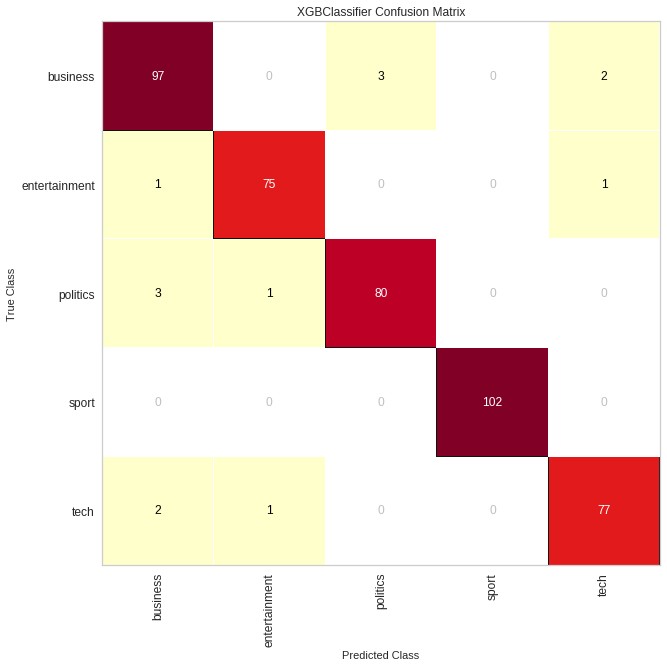

In [42]:
plt.figure(figsize=(10,10))
visualizer = ConfusionMatrix(xgb_clf, classes=classes, label_encoder=label_encoder)
visualizer.score(x_test, y_test)
visualizer.poof()

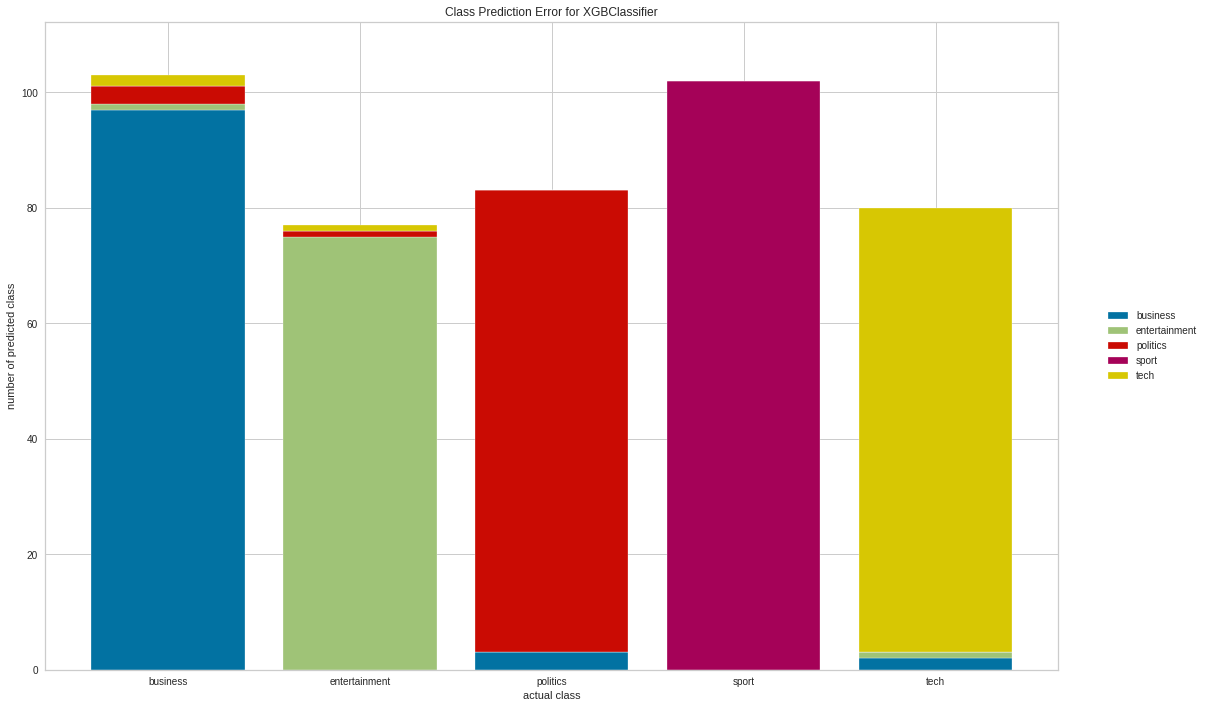

In [43]:
plt.figure(figsize=(20,10))
visualizer = ClassPredictionError(
    model=xgb_clf, classes=classes
)

visualizer.score(x_test, y_test)
visualizer.poof()

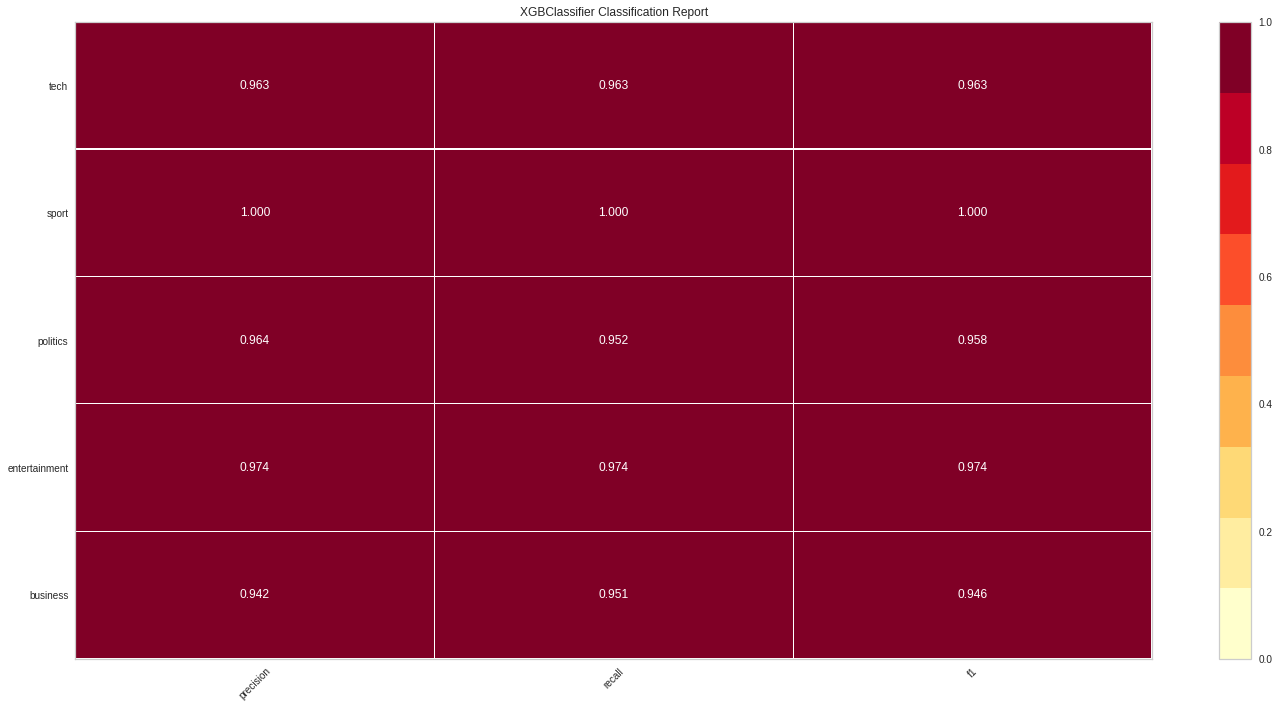

In [44]:
plt.figure(figsize=(20,10))
visualizer = ClassificationReport(model=xgb_clf, classes=classes)
visualizer.score(x_test, y_test)
visualizer.poof()